In [1]:
from collections import defaultdict
from copy import copy
import numpy as np
import operator
import os
import pickle

import pandas as pd
import tensorly as tl


import matplotlib.pyplot as plt
%pylab inline

from eval_tensor import VerbTensorEvaluator

import logging
logging.basicConfig(level=logging.INFO,
        format='%(levelname)-8s [%(lineno)d] %(message)s')

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/vtensor/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pylab.rcParams['figure.figsize'] = (20, 10)

In [3]:
#matplotlib.rcParams.update({'font.size': 14})

# 1 One-mode similarity

## 1.1 Data

### 1.1.1 [SimVerb](http://people.ds.cam.ac.uk/dsg40/simverb.html) (Gerz+ EMNLP 2016)

In [4]:
simverb = pd.read_csv('/mnt/permanent/Language/English/Data/verb-similarity/simverb-3500/SimVerb-3500.txt', 
                      sep='\t', header=None, names=['verb1', 'verb2', 'pos', 'sim', 'rel'])

In [5]:
simverb.head()

,verb1,verb2,pos,sim,rel
0,take,remove,V,6.81,SYNONYMS
1,walk,trail,V,4.81,COHYPONYMS
2,feed,starve,V,1.49,ANTONYMS
3,shine,polish,V,7.80,SYNONYMS
4,calculate,add,V,5.98,HYPER/HYPONYMS


In [6]:
simverb.describe(percentiles=[])

,sim
count,3500.000000
mean,4.291554
std,2.652621
min,0.000000
50%,4.320000
max,9.960000


In [7]:
simverb.groupby('rel').sim.describe(percentiles=[]).sort_values('count', ascending=False)

,count,mean,std,min,50%,max
rel,,,,,,
NONE,2093.0,3.431276,2.342695,0.0,3.150,9.79
HYPER/HYPONYMS,800.0,6.012525,2.104537,0.5,6.310,9.96
SYNONYMS,306.0,6.789150,2.104490,0.5,7.140,9.96
COHYPONYMS,190.0,4.435526,2.381992,0.0,4.665,9.30
ANTONYMS,111.0,0.977748,1.074232,0.0,0.660,6.04


### 1.1.2 SimLex-999

In [8]:
simlex = pd.read_csv('/mnt/permanent/Language/English/Data/SimLex-999/SimLex-999.txt', sep='\t')

In [9]:
simlex.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


* conc(w1): The concreteness rating of word1 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* conc(w2): The concreteness rating of word2 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* concQ: The quartile the pair occupies based on the two concreteness ratings. Used for some analyses in the above paper. 

* Assoc(USF): The strength of free association from word1 to word2. Values are taken from the University of South Florida Free Association Dataset. 

* SimAssoc333: Binary indicator of whether the pair is one of the 333 most associated in the dataset (according to Assoc(USF)). This subset of SimLex999 is often the hardest for computational models to capture because the noise from high association can confound the similarity rating. See the paper for more details. 

* SD(SimLex): The standard deviation of annotator scores when rating this pair. Low values indicate good agreement between the 15+ annotators on the similarity value SimLex999. Higher scores indicate less certainty. 


In [10]:
simlex.describe(percentiles=[])

,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,4.561572,3.657087,3.568629,2.501502,0.751512,0.333333,1.274505
std,2.614663,1.131050,1.159572,1.118145,1.344569,0.471641,0.366278
min,0.230000,1.190000,1.190000,1.000000,0.000000,0.000000,0.340000
50%,4.670000,3.830000,3.660000,3.000000,0.250000,0.000000,1.310000
max,9.800000,5.000000,5.000000,4.000000,8.850000,1.000000,2.180000


In [11]:
simlex.groupby('POS').size()

POS
A    111
N    666
V    222
dtype: int64

## 1.2 Testing the verb tensor

In [80]:
evalor = VerbTensorEvaluator()

cutoffs = []
for i in [1, 2, 3, 5]:
    cutoffs += list(i*10**np.arange(2, 9))

def eval_for_for(task_df0, mode_to_test):
    # normlz_vocb=True, lmbda=False, decomp_algo='tucker', weight_name='log_freq'
    data = []
    algo='tucker'#for algo in ['tucker', 'parafac']:
    for cutoff in cutoffs:
        for exp in range(10):
            rank = 2**exp
            for weight in ["iact", "iact_sali", "ldice", "ldice_sali", "log_freq", "niact", "npmi", "pmi", "pmi_sali"]:
                try:
                    score = evalor.test_sim(task_df0, mode_to_test=mode_to_test, 
                                            cutoff=cutoff, rank=rank, weight=weight, decomp_algo=algo)
                    data.append((cutoff, rank, weight, algo, score))
                except FileNotFoundError as e:
                    pass
                except ValueError as e:
                    logging.warning((cutoff, rank, e))
    df = pd.DataFrame(data, columns=['cutoff', 'rank', 'weight', 'algo', 'corr'])
    return df.sort_values('corr', ascending=False)

In [13]:
df = eval_for_for(simlex, mode_to_test='nsubj')#, cutoff=500, rank=32)['tensor_sim']

/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: invalid value encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))
/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: divide by zero encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))


In [14]:
df.head()

,cutoff,rank,weight,algo,corr
23,50000,128,pmi,tucker,0.062948
7,20000,64,log_freq,tucker,0.059838
19,50000,64,npmi,tucker,0.055741
21,50000,64,pmi_sali,tucker,0.055019
4,100000,128,log_freq,tucker,0.051032


In [15]:
df = eval_for_for(simverb, mode_to_test='ROOT')#, cutoff=500, rank=32)['tensor_sim']

/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: divide by zero encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))
/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: invalid value encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))


In [16]:
df.head()

,cutoff,rank,weight,algo,corr
22,50000,128,log_freq,tucker,0.243354
7,20000,64,log_freq,tucker,0.240879
19,50000,64,npmi,tucker,0.238769
21,50000,64,pmi_sali,tucker,0.237985
20,50000,64,pmi,tucker,0.229856


In [17]:
eval_for_for(simlex, mode_to_test='dobj').head()

/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: divide by zero encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))
/home/makrai/repo/verb-tensor/eval_tensor.py:99: RuntimeWarning: invalid value encountered in true_divide
  np.linalg.norm, 1, factors[mode_i]).reshape((-1,1))


,cutoff,rank,weight,algo,corr
23,50000,128,pmi,tucker,0.124596
7,20000,64,log_freq,tucker,0.103548
21,50000,64,pmi_sali,tucker,0.087491
22,50000,128,log_freq,tucker,0.086082
4,100000,128,log_freq,tucker,0.080799


In [18]:
def plot_cutoff(df, col):
    for weight in df.weight.unique():
        df0 = df[(df.weight==weight)&(df.rank_==256)]
        plt.plot(df0.cutoff, df0[col])
        plt.legend(df.weight.unique())

In [19]:
def plot_rank(df, col):
    for weight in df.weight.unique():
        df0 = df[(df.weight==weight)&(df.cutoff==100)]
        plt.plot(df0.rank_, df0[col])
        plt.legend(df.weight.unique())

In [20]:
if False:
    df = compare_100_256(simverb, 'ROOT', 'sim')
    plot_cutoff(df, 'sim')
    plot_rank(df, 'sim')
    df = compare_100_256(simlex, mode_to_test='nsubj', col='SimLex999')
    plot_cutoff(df, 'SimLex999')
    plot_rank(df, 'SimLex999')
    df = compare_100_256(simlex, mode_to_test='dobj', col='SimLex999')
    plot_cutoff(df, 'SimLex999')
    plot_rank(df, 'SimLex999')
    # weights = pd.unique(simverb_res.weight)

In [21]:
def plot_results(df0, col='sim', save_filen=''):#else ''
    
    df0 = df0[df0.rank_ ==256]
    weights = pd.unique(df0.sort_values(col, ascending=False).weight)
    for weight in weights:
        df = df0[df0.weight==weight].sort_values('rank_')
        plt.plot(df.rank_, df[col])#, c=color)
    #plt.xscale('log')
    _ = plt.legend(weights)
    if save_filen:
        #plt.rc('text', usetex = True)
        #plt.figure(1, figsize = (3, 2))#6, 4))
        #plt.savefig('/home/makrai/repo/paper/LREC20/verbtensor/img/{}'.format(save_filen))
        filen = '/home/makrai/repo/paper/Coling2020/verbtensor/img/{}.png'.format(save_filen)
        plt.savefig(filen)

In [22]:
#plot_results(simverb_res)#, save_filen='SimVerb')

In [23]:
#plot_results(simlex_subj, col='SimLex999')#, save_filen='simLex-subj')

In [24]:
#plot_results(simlex_obj, col='SimLex999')#, save_filen='simLex-obj')

# 2 SVO triples (_al et_ Sadrzadeh 2011--2014)

## 2.1 Datasets

  * [GS’11](http://www.cs.ox.ac.uk/activities/compdistmeaning/GS2011data.txt) provided by Grefenstette and Sadrzadeh (EMNLP 2011)
      * each verb pair takes the same subject and object
      * the task has an aspect of a verb sense disambiguation 
          * As discussed in previous work
            (Kartsaklis and Sadrzadeh, 2013; Milajevs+ 2014; Polajnar+ 2014), GS’11
      * For example, the transitive verb “run” is known as polysemous: operate/move
        * “run” and “operate” are similar when subj = “people” and obj = “company”
        * In the same [context, not similar to] “move”
  * ML’10 provided by Mitchell and Lapata (2010),
    * pairs of verb-object phrases and
  * KS’13 provided by Kartsaklis and Sadrzadeh (2013)
    * complements ML’10 by incorporating an appropriate subject for each VO
  * KS’14 provided by [Kartsaklis and Sadrzadeh (2014)](https://arxiv.org/abs/1405.2874)
    * reannotated version of KS’13 using a cloud sourcing service
  * the latter three require one to capture the topical similarity
    rather than the disambiguation aspect (Polajnar+ 2014)

In [25]:
verb_sim_data_dir = '/mnt/permanent/Language/English/Data/verb-similarity/Sadrzadeh/'

In [26]:
def read_sim_data(filen):
    return pd.read_csv(os.path.join(verb_sim_data_dir, filen), sep=' ')

### 2.1.1 Pairs of SVO triples with the same but ambiguous verb (GS11)

In [27]:
gs11 = read_sim_data('GS2011data.txt').groupby(['verb', 'subject', 'object', 'landmark', 'hilo']).mean()
print(gs11.shape)
gs11.head()

(200, 1)


input
verb   subject    object         landmark hilo          
accept government proposal       bear     LOW   2.666667
                                 receive  HIGH  2.583333
                  recommendation bear     LOW   3.500000
                                 receive  HIGH  3.333333
       lawyer     conviction     bear     LOW   3.333333

In [28]:
gs11.groupby('verb').size().sort_values(ascending=False).head()

verb
accept     20
buy        20
draw       20
meet       20
provide    20
dtype: int64

In [29]:
gs11.groupby('landmark').size().sort_values(ascending=False).head()

landmark
allege     10
attract    10
test       10
supply     10
state      10
dtype: int64

In [30]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gs12 = read_sim_data('GS2012data.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gs12.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,statistical,table,show,express,good,result,6.06
2,statistical,table,show,depict,good,result,5.90
3,recent,study,show,express,significant,correlation,5.72
4,recent,study,show,depict,significant,correlation,5.92
5,annual,figure,show,express,substantial,increase,5.74


In [31]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gsk13 = read_sim_data('pickering-judgements.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gsk13.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,private,company,file,register,annual,account,5.441860
2,private,company,file,smooth,annual,account,2.302326
3,young,woman,file,register,long,nail,2.069767
4,young,woman,file,smooth,long,nail,5.023256
5,local,government,file,register,criminal,charge,5.441860


In [32]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_mitchell = read_sim_data('emnlp2013_ml.txt').groupby(cols).mean()
print(ks13_mitchell.shape)
ks13_mitchell.head()

(108, 1)


score
subject1 verb1 object1  subject2 verb2 object2          
agent    sell  property family   buy   home     2.777778
                        group    hold  meeting  1.666667
author   write book     delegate buy   land     1.500000
                        man      hear  word     2.055556
                        writer   read  word     2.777778

In [33]:
def get_cols(i):
    return ['subject{}'.format(i), 'verb{}'.format(i), 'object{}'.format(i)]

def get_one_sent_from_pair(i):
    df = ks13_mitchell.reset_index()[get_cols(i)]
    df.columns = get_cols('')
    return df

ks13_long = pd.concat(get_one_sent_from_pair(i) for i in [1, 2])
ks13_long = ks13_long.drop_duplicates()

### 2.1.2 Kartsaklis and Sadrzadeh, Turk

In [34]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_turk = read_sim_data('emnlp2013_turk.txt').groupby(cols).mean().drop(columns=['annotator']).reset_index()
ks13_turk.head()

,subject1,verb1,object1,subject2,verb2,object2,score
0,agent,sell,property,family,buy,home,3.125000
1,agent,sell,property,group,hold,meeting,1.166667
2,author,write,book,delegate,buy,land,1.130435
3,author,write,book,man,hear,word,1.640000
4,author,write,book,writer,read,word,3.166667


In [35]:
ks13_turk.groupby('verb1').size().sort_values(ascending=False).head()

verb1
achieve    5
use        5
win        4
provide    4
fight      3
dtype: int64

In [36]:
ks13_turk.groupby('verb2').size().sort_values(ascending=False).head()

verb2
use        7
provide    5
leave      4
buy        4
reach      3
dtype: int64

### 2.1.3 [Verb prediction task by Jenatton+ (NIPS 2012)](https://everest.hds.utc.fr/doku.php?id=en:lfmnips12)

In [37]:
dataset_dir = '/mnt/permanent/Language/English/Data/verb-similarity/SVO-tensor-dataset/'
def get_index(pos):
    with open(os.path.join(dataset_dir, 'svo-{}s.lst'.format(pos))) as infile:
        return {i+1: ' '.join(line.strip().split('_')[2:-1]) for i, line in enumerate(infile)}

In [38]:
svo_df = pd.read_csv(os.path.join(dataset_dir, 'svo_data_train_1000000.dat'), sep='\t', header=None, 
                     names=['subject', 'verb', 'object'])

In [39]:
index_verb = get_index('verb')
index_noun = get_index('noun')

In [40]:
svo_df.subject = svo_df.subject.apply(index_noun.get)
svo_df.verb = svo_df.verb.apply(index_verb.get)
svo_df.object = svo_df.object.apply(index_noun.get)

In [41]:
svo_df.sample(5)

,subject,verb,object
893715,concept,include,criterion
157715,post road,include,main road
720499,test,use,blood coagulation
480076,event,go,mainstream
305129,attempt,provide,mean


## 2.2 Similarity (KS Turk)

In [42]:
evalor = VerbTensorEvaluator()

In [84]:
df = eval_for_for(ks13_turk, mode_to_test='svo')
df[df.weight=='log_freq'].sort_values('corr', ascending=False).head()

,cutoff,rank,weight,algo,corr
6,1000000,64,log_freq,tucker,0.696359
3,100000,64,log_freq,tucker,0.694396
23,50000,64,log_freq,tucker,0.690932
13,300000,64,log_freq,tucker,0.689950
30,500000,64,log_freq,tucker,0.689865


In [92]:
evalor.test_sim(ks13_turk, mode_to_test='svo', cutoff=10000, rank=64)#, decomp_algo='parafac')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/permanent/home/makrai/project/verb-tensor/cutoff/tensor/tucker_log_freq_10000_64.pkl'

In [85]:
df1 = df[df.weight=='log_freq']

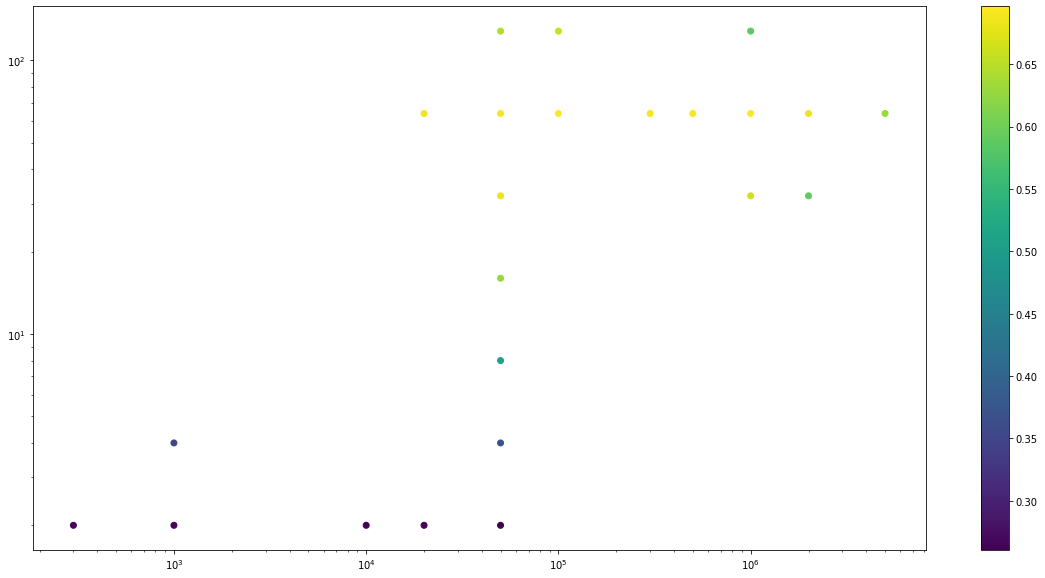

In [86]:
plt.scatter(df1.cutoff, df1['rank'], c=df1['corr'])
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [79]:
weights = ["dice_sali", "iact_info", "iact_sali", "log_dice", "log_freq", "niact", "npmi", "pmi", "salience"]

 
def eval_for_weight(task_df0, mode_to_test='svo', cutoff=2000, rank=128):
    # normlz_vocb=True, lmbda=False, decomp_algo='tucker', weight_name='log_freq'
    data = []
    for weight_name in weights:
        try:
            score_d = evalor.test_sim(task_df0, mode_to_test=mode_to_test, 
                                      cutoff=cutoff, rank=rank, weight=weight_name)
            data.append((cutoff, rank, weight_name, score_d))
        except FileNotFoundError as e:
            logging.warning(weight_name)
        except ValueError as e:
            logging.warning((cutoff, rank, e))
    df = pd.DataFrame(data, columns=['cutoff', 'rank', 'weight', 'corr'])
    return df.sort_values('corr', ascending=False)

In [48]:
#plot_cutoff(df, 'score')

In [49]:
#plot_rank(df, 'score')

In [50]:
#plot_results(df, col='score')#, save_filen='svo')

In [51]:
#df.plot.bar(x='weight', y='score')

## 2.3 Verb prediction

In [52]:
ks13_turk

,subject1,verb1,object1,subject2,verb2,object2,score
0,agent,sell,property,family,buy,home,3.125000
1,agent,sell,property,group,hold,meeting,1.166667
2,author,write,book,delegate,buy,land,1.130435
3,author,write,book,man,hear,word,1.640000
4,author,write,book,writer,read,word,3.166667
...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,1.125000
104,woman,drink,water,system,use,method,1.083333
105,worker,join,party,employee,leave,company,1.400000
106,writer,read,word,family,receive,letter,2.090909


In [53]:
ks13_turk.groupby('verb2').size().sort_values(ascending=False).head()

verb2
use        7
provide    5
leave      4
buy        4
reach      3
dtype: int64

In [54]:
evalor.predict_verb(svo_df)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/permanent/home/makrai/project/verb-tensor/cutoff/tensor/sparstensr_log_freq_2000.pkl'

## Attic: Exploring GS11

In [ ]:
svo_sim = gs11.reset_index()

In [ ]:
svo_sim.hilo = (svo_sim=='HIGH').astype(int)

In [ ]:
cols_ordered = ["subject", "verb", "landmark", "object", "input", "hilo"]

In [ ]:
svo_sim[cols_ordered].head()

In [ ]:
svo_sim.groupby('landmark').size().sort_values(ascending=False)

In [ ]:
svo_sim.groupby('verb').size().sort_values(ascending=False)

In [ ]:
svo_sim.describe(percentiles=[])

In [ ]:
svo_sim.corr(method='spearman')